/home/julian/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


{'data_root': '/media/julian/Maxtor/DATA/cmu_panoptic',
 'nodes': [1, 15, 3, 13, 8],
 'panels': [1, 6, 14, 18, 5],
 'seq_name': '160422_ultimatum1'}
step 1: elapsed 5.867535829544067
step 2: elapsed 0.09808993339538574
step 3: elapsed 2.6531598567962646
-------------------------------------------
Handle transitivity:
	Intra:		 802
	Intra(choice):	 13
	Inter:		 6506
	Inter(choice):	 277
-------------------------------------------
	Time =  45634  ms
	result: 0

	Total cost: 2774.4718596878065

# valid points:		 203
# invalid points:	 5
step 4: elapsed 45.739579916000366
step 5: elapsed 0.11995148658752441

total elapsed: 54.48114776611328


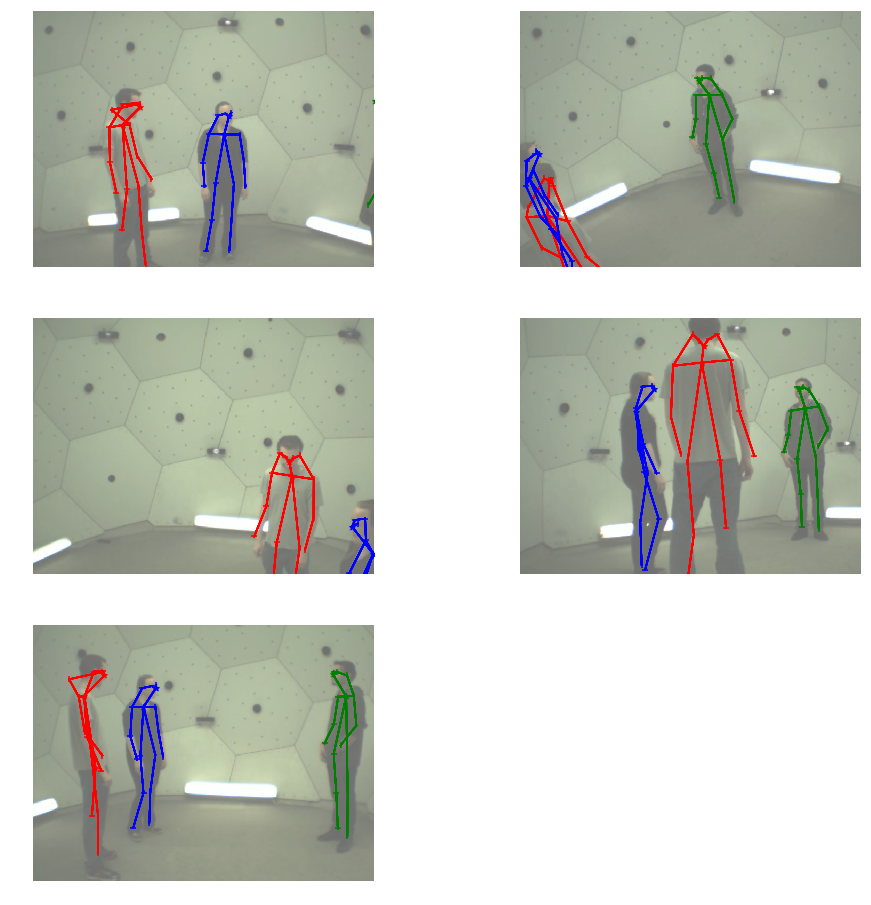

In [1]:
%matplotlib inline
# ---- settings ----
import json
from pprint import pprint
Settings = json.load(open('../settings.txt'))
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import sys
sys.path.insert(0, '../'); sys.path.insert(0, '.')
import paf_loader
from os.path import join, isdir
import numpy as np
import cv2
from cselect import color as cs
from time import time

from mvpose.data import cmu_panoptic

root = Settings['CMU']['data_root']

pprint(Settings['CMU'])
    
FRAME = 2000

panels = Settings['CMU']['panels']
nodes = Settings['CMU']['nodes']

seq_name = Settings['CMU']['seq_name']

Im, Y, Calib = cmu_panoptic.get(root, seq_name, 
                                panels, nodes, frame=FRAME)

heatmaps, pafs = paf_loader.load_confidence_map_and_paf('cmu', Im, FRAME, dir='/home/julian/Temp')

# ==================================
from mvpose import pose
from mvpose.algorithm import graphcut
from mvpose.algorithm.settings import get_settings

_start = time()
Debug, detections = pose.estimate(Calib, heatmaps, pafs,
                                  settings=get_settings(
                                      scale_to_mm=10),
                                  debug=True)
_end = time()
print('\ntotal elapsed:', _end - _start)
# ==================================


from mvpose.algorithm.candidate_selection import project_human_to_2d
from mvpose.plot.limbs import draw_mscoco_human

Humans = detections

fig = plt.figure(figsize=(16,16))

colors = ['red', 'blue', 'green']

for idx, cam in enumerate(Calib):
    ax = fig.add_subplot(3,2,1+idx)
    ax.axis('off')
    ax.set_xlim([0, 640])
    ax.set_ylim([480, 0])
    im = Im[idx]
    h,w,_ = im.shape
    ax.imshow(im, alpha=0.6)
    
    for pid, human in enumerate(Humans):
        human2d = project_human_to_2d(human, cam)
        draw_mscoco_human(ax, human, cam, colors[pid])
    
plt.show()

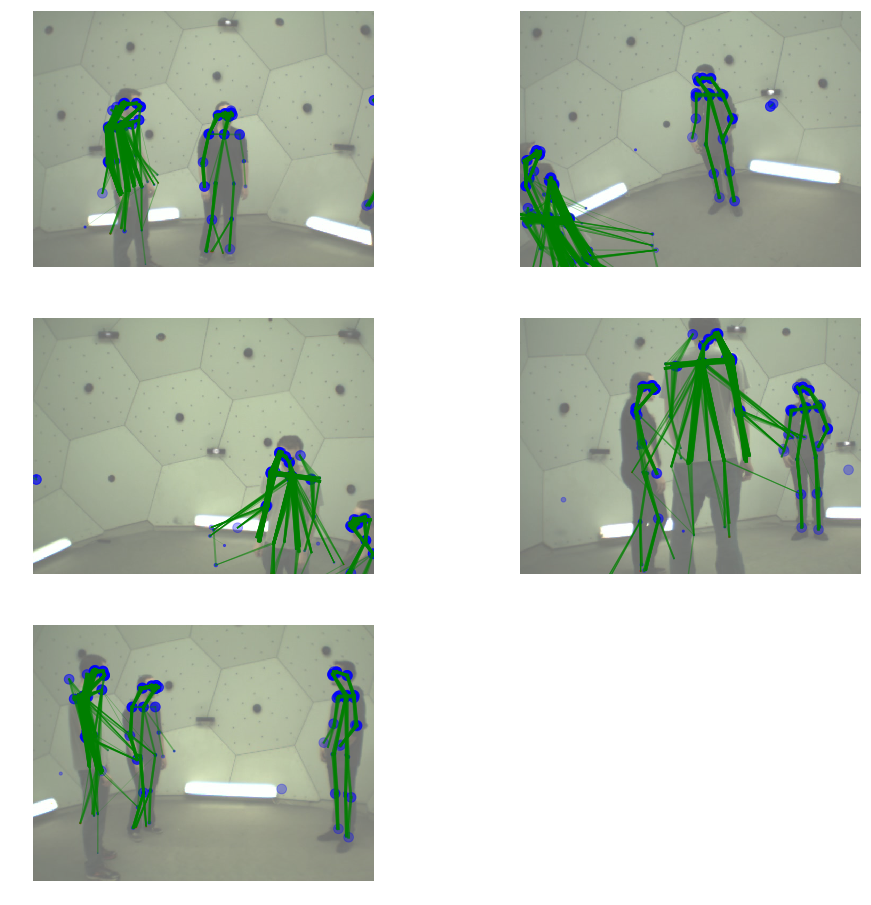

In [2]:
from mvpose.algorithm.graphcut import PBOOST_SMALL, get_unary
from mvpose.data.default_limbs import DEFAULT_LIMB_SEQ

fig = plt.figure(figsize=(16,16))

for idx, cam in enumerate(Calib):
    ax = fig.add_subplot(3,2,1+idx)
    ax.axis('off')
    ax.set_xlim(0, 640)
    ax.set_ylim(480, 0)
    im = Im[idx]
    h,w,_ = im.shape
    ax.imshow(im, alpha=0.6)
    for lid, (a, b) in enumerate(DEFAULT_LIMB_SEQ):
        candA = Debug.triangulation.peaks3d_weighted[a][:,0:3]
        candB = Debug.triangulation.peaks3d_weighted[b][:,0:3]
        W = Debug.limbs3d[lid]
        n, m = W.shape
        assert n == len(candA) and m == len(candB)
        
        ptsA2d, maskA = cam.projectPoints(candA, withmask=True, binary_mask=False)
        ptsB2d, maskB = cam.projectPoints(candB, withmask=True, binary_mask=False)

        unaryA = get_unary(Debug.triangulation.peaks3d_weighted[a])[maskA]
        unaryA = PBOOST_SMALL(np.clip(unaryA, a_min=0.00000001, a_max=0.99999999))
        unaryB = get_unary(Debug.triangulation.peaks3d_weighted[b])[maskB]
        unaryB = PBOOST_SMALL(np.clip(unaryB, a_min=0.00000001, a_max=0.99999999))
        
        colorA = ['blue' if q > 0 else 'red' for q in unaryA]
        colorB = ['blue' if q > 0 else 'red' for q in unaryB]
        
        ax.scatter(ptsA2d[maskA][:,0], ptsA2d[maskA][:,1], color=colorA, alpha=0.3, s=np.abs(unaryA) * 5)
        ax.scatter(ptsB2d[maskB][:,0], ptsB2d[maskB][:,1], color=colorB, alpha=0.3, s=np.abs(unaryB) * 5)
        
        for _a in range(len(ptsA2d)):
            for _b in range(len(ptsB2d)):
                w = W[_a,_b]
                Ax,Ay = ptsA2d[_a]
                Bx,By = ptsB2d[_b]
                if w > 0:
                    ax.plot([Ax,Bx], [Ay,By], color='green', linewidth=w*10, alpha=0.4)
                elif w > -99999:
                    ax.plot([Ax,Bx], [Ay,By], color='red', linewidth=-w*10, alpha=0.4)

plt.show()

point 0: 	 (0.6909228339791298, 0.7526801079511642)
point 1: 	 (0.36250412091612816, 0.37980346102267504)
point 2: 	 (0.6909228339791298, 0.17748265457339585)
point 3: 	 (0.6909228339791298, 0.1773708371911198)
point 4: 	 (0.6909228339791298, 0.6205273903906345)
point 5: 	 (0.7526801079511642, 0.7767969965934753)
point 6: 	 (0.7526801079511642, 0.5065328031778336)
point 7: 	 (0.27786887367255986, 0.17748265457339585)
point 8: 	 (0.27786887367255986, 0.1773708371911198)
point 9: 	 (0.7767969965934753, 0.5065328031778336)


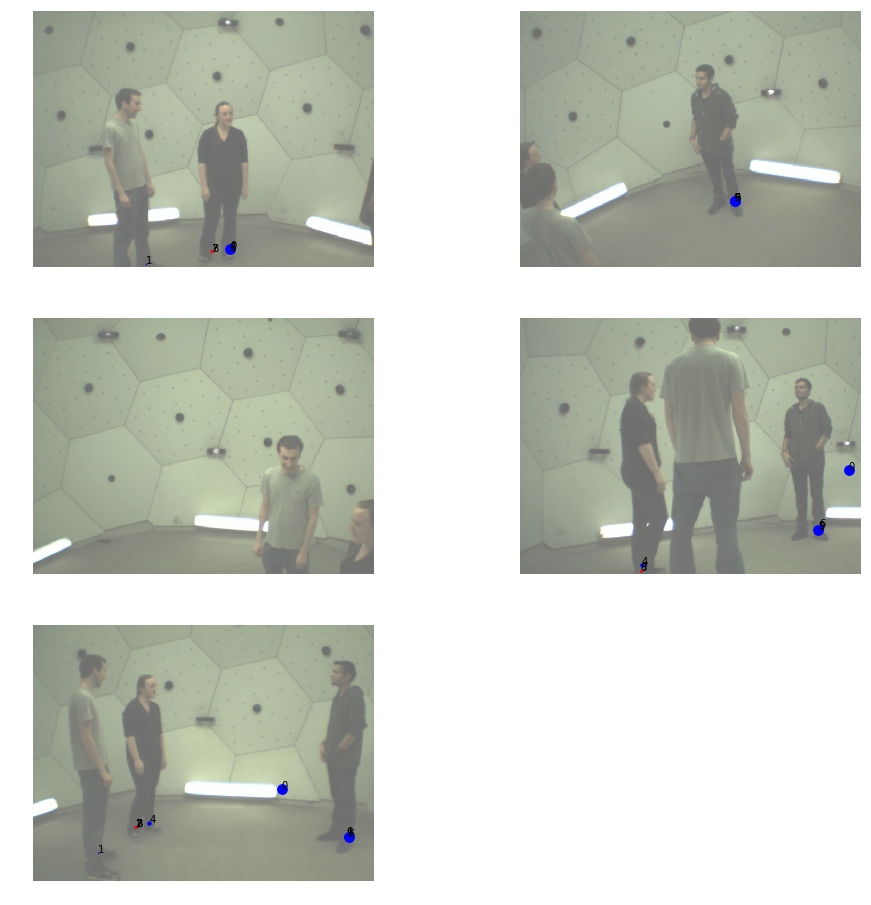

In [4]:
# foot right: 10, foot left 13
jid = 13

pts3d_w = Debug.triangulation.peaks3d_weighted[jid]
pts3d = pts3d_w[:,0:3].astype('float32')

unary = get_unary(pts3d_w)
unary = PBOOST_SMALL(np.clip(unary, a_min=0.00000001, a_max=0.99999999))

colors = ['blue' if q > 0 else 'red' for q in unary]

for i, (_,_,_,w1,w2) in enumerate(pts3d_w):
    print('point ' + str(i) + ': \t', (w1, w2))

fig = plt.figure(figsize=(16,16))

for idx, cam in enumerate(Calib):
    ax = fig.add_subplot(3,2,1+idx)
    ax.axis('off')
    ax.set_xlim(0, 640)
    ax.set_ylim(480, 0)
    im = Im[idx]
    h,w,_ = im.shape
    ax.imshow(im, alpha=0.6)
    
    pts2d = cam.projectPoints(pts3d)
    for i, (x,y) in enumerate(pts2d):
        ax.scatter(x, y, color=colors[i], s=np.abs(unary)[i]*5)
        if x > 0 and x < 640 and y > 0 and y < 480:
            ax.text(x,y, str(i))
    
plt.show()